In [2]:
import pickle
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
#winsorization
import scipy.stats as stats

NameError: name '_C' is not defined

In [ ]:
test = pd.read_pickle("Clean_S&P2021.pkl")

In [ ]:
walgreens = test # modify this line to run the entire dataframe

In [ ]:
# Load pre-trained model and tokenizer
model_name = "ProsusAI/finbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load your DataFrame
# df = pd.read_csv('your_data.csv')  # Uncomment this line if your data is in a CSV file
# For this example, let's create a DataFrame with dummy data
df = walgreens

In [ ]:
# Define a dictionary of class labels
class_labels = {0: "negative", 1: "neutral", 2: "positive"}

def predict_sentiment(text):
    # Tokenize the text and return a dictionary of tensors
    inputs = tokenizer(text, truncation=True, max_length=512, padding='max_length', return_tensors="pt")

    # Initialize a list to hold the probabilities for each chunk
    chunk_probs = []

    # Process the input tensors in chunks of 512 tokens
    for i in range(0, inputs["input_ids"].size(1), 512):
        # Create a dictionary for the current chunk
        chunk = {key: tensor[:, i:i+512] for key, tensor in inputs.items()}

        # Run the chunk through the model and get the logits
        with torch.no_grad():
            logits = model(**chunk).logits

        # Compute the probabilities
        probs = logits.softmax(dim=-1)

        # Add the probabilities to the list
        chunk_probs.append(probs)

    # Average the probabilities across all chunks
    avg_probs = torch.mean(torch.stack(chunk_probs), dim=0)

    # Get the class with the highest average probability
    class_idx = avg_probs.argmax().item()

    # Get the sentiment score
    sentiment_score = avg_probs.max().item()

    # Get the individual probabilities for each sentiment class
    negative_prob, neutral_prob, positive_prob = avg_probs.tolist()[0]

    # Return the predicted class label, the sentiment score, and the individual probabilities
    return class_labels[class_idx], sentiment_score, negative_prob, neutral_prob, positive_prob


In [ ]:
# will modify the dataframe
df['sentiment'], df['sentiment_score'], df['negative_prob'], df['neutral_prob'], df['positive_prob'] = zip(*df['content'].apply(predict_sentiment))

In [ ]:
# df

In [ ]:
##############remove this in real project#########
# df.to_csv('output.csv')

### get ticker for each company in sentiment output table

In [25]:
##############remove this in real project#########
df=pd.read_csv('finBERT_S&P.csv',index_col=0)
df=df[df['sentiment']!='neutral']
df.head(3)


,companyid,CIK,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,sentiment,sentiment_score,negative_prob,neutral_prob,positive_prob
0,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",positive,0.939536,0.041608,0.018855,0.939536
1,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",positive,0.939940,0.039617,0.020444,0.939940
2,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,positive,0.936125,0.029380,0.034495,0.936125


In [26]:
sp_500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp_500
cik = []

for i in range(len(sp_500["CIK"])):
    temp = str(sp_500["CIK"][i])
    while len(temp) != 10:
        temp = "0" + temp
    cik.append(temp)
sp_500["CIK"] = pd.Series(cik)

In [27]:
import wrds
db = wrds.Connection()

Enter your WRDS username [tingyuchang]:cassgan96
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [28]:
CIK = tuple(sp_500['CIK'])
sql_query = 'SELECT * from ciq.wrds_cik WHERE cik IN'
sql_query += f'{CIK}'
sql_query
# Run query,  result in Pandas dataframe format
data = db.raw_sql(sql_query)
data=data.rename(columns={'cik': 'CIK'})

In [29]:
## merge on cik and get signal 
data_ticker= pd.merge(data, sp_500, on='CIK', how='inner')
data_ticker=data_ticker[['companyid','Symbol','GICS Sector']]
######## uncomment for full data set ##########
df_new=pd.merge(df, data_ticker, on='companyid', how='inner')
#test dataset 
# df_new=pd.merge(df, data_ticker, on='companyid', how='inner').iloc[:100]
#generate position

df_new['position'] = df_new['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)

###remove this in real project
from datetime import datetime
df_new['mostimportantdateutc']= df_new['mostimportantdateutc'].apply(lambda x:datetime.strptime(str(x), "%Y-%m-%d"))
df_new.head(3)

,companyid,CIK,Symbol_x,Security,GICS Sector_x,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,sentiment,sentiment_score,negative_prob,neutral_prob,positive_prob,Symbol_y,GICS Sector_y,position
0,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",positive,0.939536,0.041608,0.018855,0.939536,T,Communication Services,1
1,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",positive,0.939940,0.039617,0.020444,0.939940,T,Communication Services,1
2,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-10-23,9886.0,Good morning ladies and gentlemen and welcome...,positive,0.936125,0.029380,0.034495,0.936125,T,Communication Services,1


In [30]:
df_new.isna().sum()


companyid                0
CIK                      0
Symbol_x                 0
Security                 0
GICS Sector_x            0
GICS Sub-Industry        0
Headquarters Location    0
companyname              0
mostimportantdateutc     0
word_counts              0
content                  0
sentiment                0
sentiment_score          0
negative_prob            0
neutral_prob             0
positive_prob            0
Symbol_y                 0
GICS Sector_y            0
position                 0
dtype: int64

In [35]:
data=df_new
data.head(2)

,companyid,CIK,Symbol_x,Security,GICS Sector_x,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,word_counts,content,sentiment,sentiment_score,negative_prob,neutral_prob,positive_prob,Symbol_y,GICS Sector_y,position
0,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-01-26,8416.0,"Good morning, ladies and gentlemen, and welcom...",positive,0.939536,0.041608,0.018855,0.939536,T,Communication Services,1
1,100231,732717,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",AT&T Inc.,2006-04-25,8143.0,"Good morning, ladies and gentlemen, and welcom...",positive,0.939940,0.039617,0.020444,0.939940,T,Communication Services,1


In [62]:
data.loc[data["Symbol_x"] == "BF.B", "Symbol_x"] ="BF-B"
data.reset_index(drop = True, inplace = True)
data.insert(2, "year", pd.to_datetime(data["mostimportantdateutc"]).dt.year)
data["mostimportantdateutc"] = pd.to_datetime(data["mostimportantdateutc"])

#### Train test splie

In [63]:
## shuffle data so that it's not sorted by company name, and the 80/20 train test split
# shuffled_df = data.sample(frac=1, random_state=42)
shuffled_df=data.sort_values('mostimportantdateutc')
# train_factor=int(0.8*len(shuffled_df))
# test_factor=int(0.2*len(shuffled_df))
# train=shuffled_df.iloc[:train_factor]
# test=shuffled_df.iloc[-test_factor:]
train=shuffled_df[shuffled_df['year']<2019]
test=shuffled_df[shuffled_df['year']>2018]



print(len(train),len(test))

19752 8691


#### Import Historical Market Data

In [64]:
import yfinance as yf
def import_stock_data(ticker, start_date = "2006-01-17", end_date = "2023-05-25"):
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    data_dict[ticker] = pd.DataFrame(stock_data)

data_dict = {}
for i in data["Symbol_x"].unique():
    import_stock_data(i)


In [65]:
from datetime import timedelta

def stock_returns(data,  calendar_days):

    initial_data=data
    groupby_data = initial_data.groupby(["mostimportantdateutc", "Symbol_x"]).sum()
    each_returns = []
    for iterations in range(len(groupby_data.index)):
        stock_returns = []
        # Example usage 
        ticker =  groupby_data.index[iterations][1]
        start_date = groupby_data.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]

        for i in range(1, calendar_days):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * groupby_data["position"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = groupby_data.index)

In [66]:
trainer = stock_returns(train, 91).dropna()


/var/folders/h9/10gwrnq51450ynynk6gp_hgm0000gn/T/ipykernel_5265/1402706667.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby_data = initial_data.groupby(["mostimportantdateutc", "Symbol_x"]).sum()


In [67]:
trainer.head(10)

0         1         2         3   \
mostimportantdateutc Symbol_x                                           
2006-02-22           CRM      -0.088204 -0.094102 -0.086595 -0.065684   
2006-02-23           PARA     -0.018800 -0.006800 -0.021600 -0.014000   
2006-05-31           COST      0.080279  0.064741  0.047211  0.046016   
2006-07-14           GE        0.072779  0.069914  0.057880  0.069341   
2006-07-18           IBM      -0.094405 -0.101429 -0.108809 -0.095357   
2006-07-19           AAPL     -0.271786 -0.269138 -0.260713 -0.254574   
                     EBAY     -0.444595 -0.448649 -0.434009 -0.444595   
                     INTC     -0.252296 -0.250109 -0.235680 -0.233056   
                     JNPR     -0.342683 -0.362786 -0.356241 -0.359514   
                     MSI      -0.110151 -0.118790 -0.087689 -0.066955   

                                     4         5         6         7   \
mostimportantdateutc Symbol_x                                           
2006-02-22           CRM      -0.013137 -0.015550  0.019839 -0.024933   
2006-02-23           PARA     -0.037600 -0.040800 -0.040800 -0.025600   
2006-05-31           COST      0.041633  0.064741  0.056574  0.042032   
2006-07-14           GE        0.075931  0.065330  0.063037  0.063610   
2006-07-18           IBM      -0.096548 -0.097262 -0.093452 -0.083810   
2006-07-19           AAPL     -0.231223 -0.236880 -0.210520 -0.181993   
                     EBAY     -0.449775 -0.466216 -0.449775 -0.457883   
                     INTC     -0.234805 -0.236117 -0.205072 -0.212943   
                     JNPR     -0.373072 -0.376812 -0.360916 -0.371201   
                     MSI      -0.056155 -0.044924 -0.028510 -0.016847   

                                     8         9   ...        53        54  \
mostimportantdateutc Symbol_x                      ...                       
2006-02-22           CRM      -0.000536  0.013941  ... -0.123593 -0.133244   
2006-02-23           PARA     -0.034400 -0.041600  ...  0.036800  0.026400   
2006-05-31           COST      0.048406  0.055378  ...  0.034861  0.032868   
2006-07-14           GE        0.064470  0.053868  ... -0.011461 -0.017192   
2006-07-18           IBM      -0.078452 -0.093571  ... -0.027976 -0.010714   
2006-07-19           AAPL     -0.191382 -0.179586  ... -0.092682 -0.099302   
                     EBAY     -0.467342 -0.482207  ... -0.326577 -0.313964   
                     INTC     -0.227809 -0.230870  ... -0.089637 -0.091386   
                     JNPR     -0.378682 -0.381487  ... -0.170173 -0.149135   
                     MSI      -0.028942  0.002160  ...  0.095896  0.111447   

                                     55        56        57        58  \
mostimportantdateutc Symbol_x                                           
2006-02-22           CRM      -0.163539 -0.164075 -0.182306 -0.191153   
2006-02-23           PARA      0.026400  0.053200  0.032000  0.014000   
2006-05-31           COST      0.046813  0.024502  0.027689  0.005976   
2006-07-14           GE       -0.023209 -0.034384 -0.039828 -0.035530   
2006-07-18           IBM      -0.012857 -0.010238  0.000000  0.002262   
2006-07-19           AAPL     -0.106644 -0.101709 -0.111579 -0.118561   
                     EBAY     -0.338063 -0.335811 -0.333784 -0.344595   
                     INTC     -0.097945 -0.098382 -0.086576 -0.086576   
                     JNPR     -0.153810 -0.165965 -0.189808 -0.215054   
                     MSI       0.107559  0.097624  0.089849  0.081209   

                                     59        60        61        62  
mostimportantdateutc Symbol_x                                          
2006-02-22           CRM      -0.231635 -0.234584 -0.212064 -0.213137  
2006-02-23           PARA      0.008400  0.010400 -0.006000  0.016000  
2006-05-31           COST     -0.011753 -0.032072 -0.020717 -0.018924  
2006-07-14           GE       -0.036103 -0.040115 -0.036390 -0.037822  
2006-07-18           IBM       0.0022

#### Hit Rate

In [68]:
len(trainer[trainer[0]>0])/len(trainer[0])

0.6086149275900483

#### Equal Weight

In [75]:
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
def stock_returns(data, year, calendar_days):
    initial_data = data[data["year"] == year]
    groupby_data = initial_data.groupby(["mostimportantdateutc", "Symbol_x"]).sum()
    each_returns = []
    for iterations in range(len(groupby_data.index)):
        stock_returns = []
        # Example usage 
        ticker =  groupby_data.index[iterations][1]
        start_date = groupby_data.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]
        # Import stock data
        # stock_data = import_stock_data(ticker, start_date, end_date) 
        for i in range(1, calendar_days):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * groupby_data["position"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = groupby_data.index)
def overall_train_test(data, train_year = 13):
    optimal_holding_dict = {}
    for i in range(2006, 2006+train_year):
        daily_returns = stock_returns(data, i, 91).sum()
        optimal_holding = daily_returns[daily_returns == daily_returns.max()].index[0]
        optimal_holding_dict.update({i : optimal_holding})

    values = list(optimal_holding_dict.values())
    counter = Counter(values)
    most_common = counter.most_common()

    # Find the lowest value among the most frequent values
    most_frequent_values = [value for value, count in most_common if count == most_common[0][1]]
    holding_period = min(most_frequent_values)    
    return holding_period

In [76]:
optimal_holding = overall_train_test(train)
optimal_holding

57

In [78]:
# equalweight_PL=trainer.groupby('mostimportantdateutc').mean()

# df=pd.DataFrame(index=equalweight_PL.index)
# threshold = 0.05  # Set the proportion of extreme values to be capped
# for column in equalweight_PL.columns:
#     winsorized_column = stats.mstats.winsorize(equalweight_PL[column], limits=[threshold, threshold])
#     df[column] = winsorized_column
# optimal_holding=df.idxmax(axis=1)
# print(optimal_holding.describe())
# print('Optimal holding for equal weight is: ',round(optimal_holding.mean())," days")

In [79]:
# df[34].mean()

#### Test Set

In [216]:
def stock_returns(data,  calendar_days):

    initial_data=data
    groupby_data = initial_data.groupby(["mostimportantdateutc", "Symbol_x"]).sum()
    each_returns = []
    for iterations in range(len(groupby_data.index)):
        stock_returns = []
        # Example usage 
        ticker =  groupby_data.index[iterations][1]
        start_date = groupby_data.index[iterations][0]
        # days = calendar_days
        stock_data = data_dict[ticker]

        for i in range(1, calendar_days):
            end_date = start_date + timedelta(days = i)
            if end_date in stock_data.index:
                terminal_return = ((stock_data["Close"].loc[end_date]/stock_data["Open"].iloc[1]) - 1)
                position_return = terminal_return * groupby_data["position"][iterations]
                stock_returns.append(position_return)
            else:
                pass
        each_returns.append(stock_returns)
    return pd.DataFrame(each_returns, index = groupby_data.index)


In [217]:
test_equalweight = pd.DataFrame(stock_returns(test, 91).dropna().groupby('mostimportantdateutc').mean()[57])
test_equalweight.head()

,57
mostimportantdateutc,
2019-02-19,-0.522080
2019-02-20,1.016203
2019-02-21,0.469108
2019-02-22,0.532600
2019-02-25,3.443922


In [218]:
threshold = 0.05  # Set the proportion of extreme values to be capped
winsorized = stats.mstats.winsorize(test_equalweight[57], limits=[threshold, threshold])
test_equalweight['winz']=winsorized 

In [219]:
test_equalweight.describe()

,57,winz
count,189.000000,189.000000
mean,2.490230,2.416395
std,5.222114,3.624826
min,-24.888326,-4.158231
25%,0.541076,0.541076
50%,1.829623,1.829623
75%,3.949601,3.949601
max,25.860576,11.478846


In [220]:
test_equalweight['winz'].mean()

2.416394963986906

<AxesSubplot: >

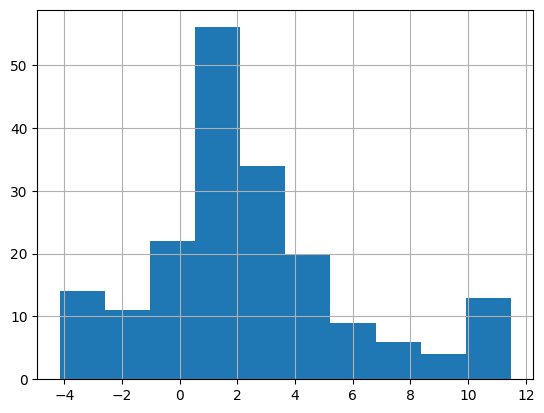

In [221]:
test_equalweight['winz'].hist()

#### Sentiment Weight

In [222]:
# ### Regenerating train test set by dates
# ## unshuffle data so that it's not sorted by company name, and the 80/20 train test split
# unshuffled_df = data.sort_values('mostimportantdateutc')
# # train_factor=int(0.8*len(unshuffled_df))
# test_factor=int(0.2*len(unshuffled_df))
# # train=unshuffled_df.iloc[:train_factor]
# test=unshuffled_df.iloc[-test_factor:]
# print(len(test))

In [223]:
# test.head(3)

In [224]:
weights_df=pd.DataFrame(test[['mostimportantdateutc','sentiment_score']] \
    .groupby('mostimportantdateutc')['sentiment_score'].sum())
weights_df
weighted_df= pd.merge(test, weights_df, on='mostimportantdateutc', how='inner')
weighted_df.describe()
weighted_df['weight']=weighted_df['sentiment_score_x']/weighted_df['sentiment_score_y']
weighted_df['position']=weighted_df['weight']*weighted_df['position']
weighted_df.head(3)

,companyid,CIK,year,Symbol_x,Security,GICS Sector_x,GICS Sub-Industry,Headquarters Location,companyname,mostimportantdateutc,...,sentiment,sentiment_score_x,negative_prob,neutral_prob,positive_prob,Symbol_y,GICS Sector_y,position,sentiment_score_y,weight
0,374372246,1679273,2019,LW,Lamb Weston,Consumer Staples,Packaged Foods & Meats,"Eagle, Idaho","Lamb Weston Holdings, Inc.",2019-01-04,...,negative,0.510224,0.510224,0.016776,0.473000,LW,Consumer Staples,-1.000000,0.510224,1.000000
1,258589,16918,2019,STZ,Constellation Brands,Consumer Staples,Distillers & Vintners,"Victor, New York","Constellation Brands, Inc.",2019-01-09,...,negative,0.702988,0.702988,0.010541,0.286471,STZ,Consumer Staples,-0.432089,1.626953,0.432089
2,30763,920760,2019,LEN,Lennar,Consumer Discretionary,Homebuilding,"Miami, Florida",Lennar Corporation,2019-01-09,...,positive,0.923965,0.050482,0.025553,0.923965,LEN,Consumer Discretionary,0.567911,1.626953,0.567911


In [225]:
test_sentiment_weight = pd.DataFrame(stock_returns(weighted_df, 91).dropna().groupby('mostimportantdateutc').mean()[57])
test_sentiment_weight

,57
mostimportantdateutc,
2019-02-19,-0.069407
2019-02-20,0.072492
2019-02-21,0.038646
2019-02-22,0.083080
2019-02-25,1.073518
...,...
2022-09-21,-0.298091
2022-09-22,0.177690
2023-02-21,0.561562


In [226]:
threshold = 0.05  # Set the proportion of extreme values to be capped
winsorized = stats.mstats.winsorize(test_sentiment_weight[57], limits=[threshold, threshold])
test_sentiment_weight['winz']=winsorized 

In [227]:
test_sentiment_weight['winz'].mean()

0.6250751909933426

<AxesSubplot: >

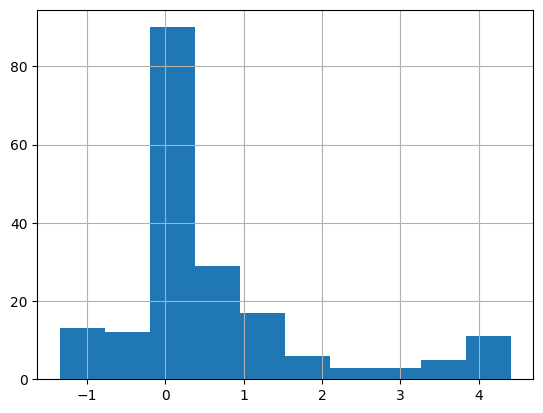

In [228]:
test_sentiment_weight['winz'].hist()

#### Results Plotting

In [229]:
import matplotlib.pyplot as plt

In [230]:
GSPC = yf.download('^GSPC', start='2019-02-15', end='2023-02-24', progress=False)['Close']

In [233]:
benchmark=pd.DataFrame(GSPC)
benchmark=pd.DataFrame(GSPC.pct_change())  
benchmark['Benchmark Return']=((1 + benchmark['Close']).cumprod() - 1)*100
# benchmark.plot()

In [236]:
results=benchmark
results= pd.merge(results,test_equalweight, left_index=True, right_index=True,how='left')
results= pd.merge(results,test_sentiment_weight, left_index=True, right_index=True,how='left')

results['Equal Weight Strategy']=results['winz_x'].cumsum()
results['Sentiment Weight Strategy']=results['winz_y'].cumsum()

results=results.fillna(method='ffill')

results

,Close,Benchmark Return,57_x,winz_x,57_y,winz_y,Equal Weight Strategy,Sentiment Weight Strategy
Date,,,,,,,,
2019-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-19,0.001499,0.149874,-0.522080,-0.522080,-0.069407,-0.069407,-0.522080,-0.069407
2019-02-20,0.001777,0.327852,1.016203,1.016203,0.072492,0.072492,0.494123,0.003086
2019-02-21,-0.003526,-0.025948,0.469108,0.469108,0.038646,0.038646,0.963230,0.041732
2019-02-22,0.006411,0.614996,0.532600,0.532600,0.083080,0.083080,1.495830,0.124812
...,...,...,...,...,...,...,...,...
2023-02-16,-0.013789,47.370290,0.531167,0.531167,0.177690,0.177690,445.621003,117.189857
2023-02-17,-0.002767,46.962457,0.531167,0.531167,0.177690,0.177690,445.621003,117.189857
2023-02-21,-0.020041,44.017148,6.330280,6.330280,0.561562,0.561562,451.951283,117.751420


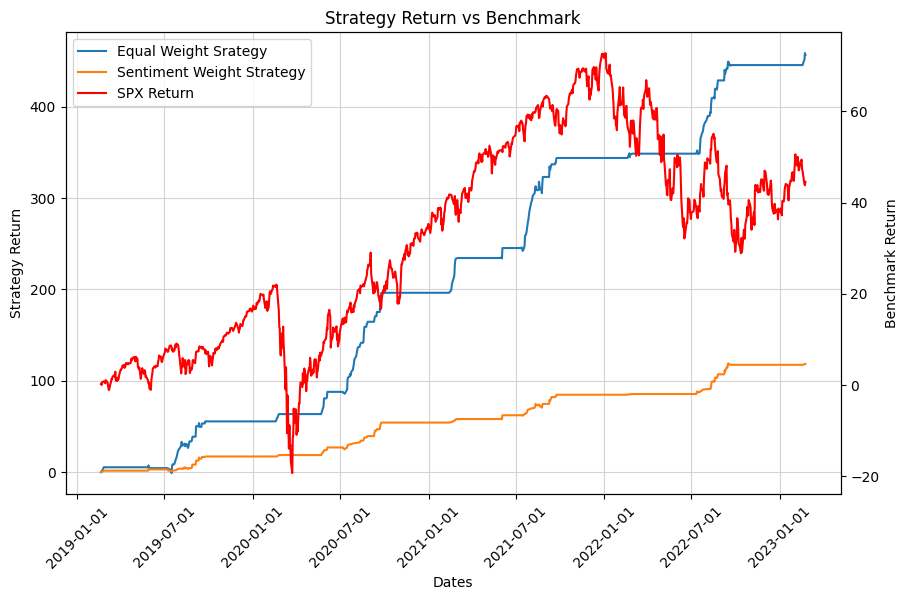

In [249]:

fig, ax1 = plt.subplots(figsize=(10, 6))

x=results.index
y1=results['Equal Weight Strategy']
y2=results['Sentiment Weight Strategy']
y3=results['Benchmark Return']

# Plotting the first column on the primary y-axis
ax1.plot(x, y1, label='Equal Weight Srategy')
ax1.plot(x, y2, label='Sentiment Weight Strategy')

# Adding labels and title to the primary y-axis
ax1.set_xlabel('Dates')
ax1.set_ylabel('Strategy Return')
ax1.set_title('Strategy Return vs Benchmark')

# Creating a secondary y-axis
ax2 = ax1.twinx()

# Plotting the third column on the secondary y-axis
ax2.plot(x, y3, 'r', label='SPX Return')

# Adding label to the secondary y-axis
ax2.set_ylabel('Benchmark Return')

import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_tick_params(rotation=45)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_tick_params(rotation=45)

ax1.grid(color='lightgray')
# Combining legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

# Displaying the plot
plt.show()